In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


AUTOMATED ANALYSIS OF SEIZURE SEMIOLOGY AND LOCALIZATION OF FOCAL EPILEPSY


Step 1: Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
from scipy.signal import butter, filtfilt
import os
from collections import Counter
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


Step 2: Load Metadata

In [3]:
# Load metadata
metadata_path = '/content/drive/MyDrive/seizure dataset/metadata_guineabissau.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of metadata
print("Metadata Preview:")
print(metadata.head())  # Shows the first 5 rows of the dataset


Metadata Preview:
   subject.id     Group              Eyes.condition  \
0           1  Epilepsy  closed-3min-then-open-2min   
1           2   Control  open-3min-then-closed-2min   
2           3  Epilepsy  closed-3min-then-open-2min   
3           4  Epilepsy  closed-3min-then-open-2min   
4           5   Control  closed-3min-then-open-2min   

                                       Remarks  recordedPeriod  \
0                 by 45s reposition electrodes             301   
1                                          NaN             309   
2                                          NaN             309   
3  Green lights not shown, but good EEG traces             299   
4                                          NaN             302   

          startTime  
0  27-05-2020 14:33  
1  26-05-2020 22:44  
2  27-05-2020 14:26  
3  27-05-2020 15:23  
4  23-05-2020 19:09  


Step 3:Displaying EEG data for each subject

In [4]:
# Directory containing EEG signal files
data_dir = '/content/drive/MyDrive/seizure dataset/data'

# List all EEG signal files in the directory
eeg_files = os.listdir(data_dir)

# Loop through the EEG files and display them
for eeg_file in eeg_files:
    eeg_file_path = os.path.join(data_dir, eeg_file)

    # Read and display EEG data for each subject
    eeg_data = pd.read_csv(eeg_file_path)
    print(f"EEG Data for {eeg_file}:")
    print(eeg_data)  # Display the entire EEG dataset for the current subject
    print("\n" + "="*50 + "\n")  # Separator for clarity


EEG Data for signal-1.csv:
       Unnamed: 0          AF3          AF4           F3           F4  \
0               1  4426.153846  3994.871795  4408.205128  3847.692308   
1               2  4420.512821  3986.666667  4394.358974  3836.923077   
2               3  4413.846154  3986.153846  4386.666667  3831.794872   
3               4  4407.692308  3984.615385  4384.102564  3832.820513   
4               5  4407.179487  3978.974359  4382.564103  3832.307692   
...           ...          ...          ...          ...          ...   
38523       38524  4049.230769  3826.666667  4003.589744  3550.256410   
38524       38525  4056.410256  3832.307692  4002.051282  3554.358974   
38525       38526  4060.512821  3835.897436  4006.666667  3561.538462   
38526       38527  4052.820513  3827.179487  4006.666667  3559.487179   
38527       38528  4047.692308  3823.589744  4003.589744  3552.820513   

                F7           F8          FC5          FC6           O1  ...  \
0      4690.25641

Step 4: Define Channel-to-Lobe Mapping and Semiology Mapping


In [5]:
# Define mapping of channels to lobes
channel_to_lobe = {
    'AF3': 'Frontal', 'AF4': 'Frontal', 'F3': 'Frontal', 'F4': 'Frontal',
    'F7': 'Frontal', 'F8': 'Frontal', 'T7': 'Temporal', 'T8': 'Temporal',
    'P7': 'Parietal', 'P8': 'Parietal', 'O1': 'Occipital', 'O2': 'Occipital'
}

# Lobe-based semiology mapping
lobe_to_semiology = {
    'Frontal': 'Motor',
    'Temporal': 'Auditory',
    'Parietal': 'Cognitive',
    'Occipital': 'Visual'
}


Step 5: Define Signal Processing Functions
**bold text**

In [6]:
# Function to apply a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs=128.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Function to compute band-specific power with log transformation
def compute_band_power(data, fs=128.0, bands=[(0.5, 4), (4, 8), (8, 13), (13, 30), (30, 50)]):
    power_features = []
    for low, high in bands:
        filtered_data = bandpass_filter(data, low, high, fs)
        power = np.log10(np.mean(filtered_data**2) + 1e-6)  # Log-transform
        power_features.append(power)
    return power_features


Step 6: Feature Extraction

In [7]:
# Extract features for each subject
def calculate_features(eeg_file):
    eeg_data = pd.read_csv(eeg_file)
    features = {}

    for channel, lobe in channel_to_lobe.items():
        if channel in eeg_data.columns:
            band_powers = compute_band_power(eeg_data[channel].values)
            features[f'{lobe}_Delta'] = band_powers[0]
            features[f'{lobe}_Theta'] = band_powers[1]
            features[f'{lobe}_Alpha'] = band_powers[2]
            features[f'{lobe}_Beta'] = band_powers[3]
            features[f'{lobe}_Gamma'] = band_powers[4]

    return features


Step 7: Prepare the Dataset

In [8]:
# Process metadata and extract features
def prepare_dataset():
    data = []
    labels = []
    subject_ids = []

    for _, row in metadata.iterrows():
        subject_id = row['subject.id']
        group = 1 if row['Group'] == 'Epilepsy' else 0
        eeg_file = os.path.join(data_dir, f'signal-{subject_id}.csv')

        if os.path.exists(eeg_file):
            features = calculate_features(eeg_file)
            data.append(features)
            labels.append(group)
            subject_ids.append(subject_id)

    return pd.DataFrame(data), np.array(labels), subject_ids


Step 8: Display the Feature Dataset

In [9]:
# Prepare dataset
X, y, subject_ids = prepare_dataset()

# Show the first few rows of the dataset
print("Feature dataset:\n", X.head())
print("Labels:\n", y[:10])  # Display first 10 labels

# Display class distribution
print("Class distribution:", Counter(y))


Feature dataset:
    Frontal_Delta  Frontal_Theta  Frontal_Alpha  Frontal_Beta  Frontal_Gamma  \
0       3.379482       2.365041       1.980952      1.766989       1.125384   
1       3.948176       3.223444       2.690931      2.666817       1.735220   
2       3.560248       2.097976       1.802811      1.365328       0.786533   
3       2.254060       1.066845       0.968600      1.170278       0.548751   
4       2.903155       1.706772       1.599543      1.315588       0.696757   

   Temporal_Delta  Temporal_Theta  Temporal_Alpha  Temporal_Beta  \
0        3.775212        2.509719        1.619965       1.622657   
1        3.989761        3.329574        3.050719       3.080394   
2        3.152659        1.871843        1.792213       1.324382   
3        2.353217        1.156863        1.029204       1.216819   
4        2.934960        1.647259        1.512084       1.403759   

   Temporal_Gamma  Parietal_Delta  Parietal_Theta  Parietal_Alpha  \
0        1.003478        3.53

Step 9: Normalize Features

In [11]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)


Step 10: Handle Class Imbalance

In [12]:
print("Original class distribution:", Counter(y))

try:
    adasyn = ADASYN(random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X_normalized, y)
    print("ADASYN applied successfully.")
except ValueError as e:
    print("ADASYN failed:", e)
    print("Falling back to BorderlineSMOTE.")
    smote = BorderlineSMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_normalized, y)

print("Resampled class distribution:", Counter(y_resampled))


Original class distribution: Counter({1: 51, 0: 46})
ADASYN failed: No samples will be generated with the provided ratio settings.
Falling back to BorderlineSMOTE.
Resampled class distribution: Counter({1: 51, 0: 51})


Step 11: Split Data for Training


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


Step 12: Tune XGBoost Model

In [14]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best hyperparameters:", random_search.best_params_)
best_model = random_search.best_estimator_


Best hyperparameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


Step 13: Train and Evaluate Ensemble Model

In [15]:
rf = RandomForestClassifier(random_state=42)
ensemble = VotingClassifier(estimators=[('xgb', best_model), ('rf', rf)], voting='soft')
ensemble.fit(X_train, y_train)

y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAUC-ROC Score:", roc_auc_score(y_test, ensemble.predict_proba(X_test)[:, 1]))


Accuracy: 0.7619047619047619

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.73      0.80      0.76        10

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21


Confusion Matrix:
[[8 3]
 [2 8]]

AUC-ROC Score: 0.8636363636363636


Step 14: Graphs for Analysis

Confusion Matrix Visualization


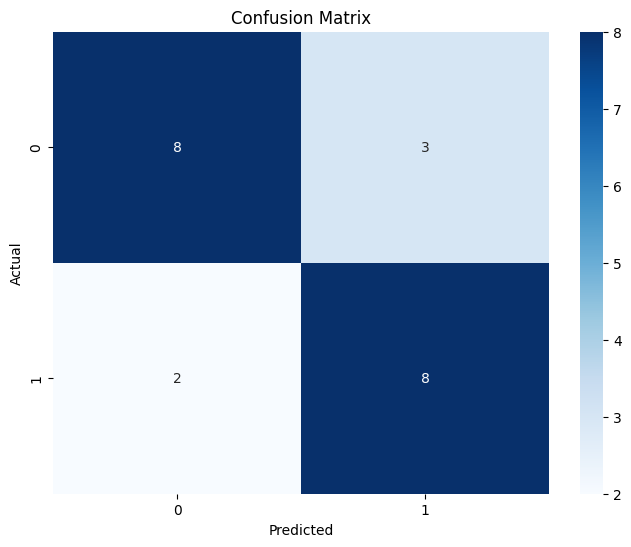

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Corrected Code for Plotting ROC Curve


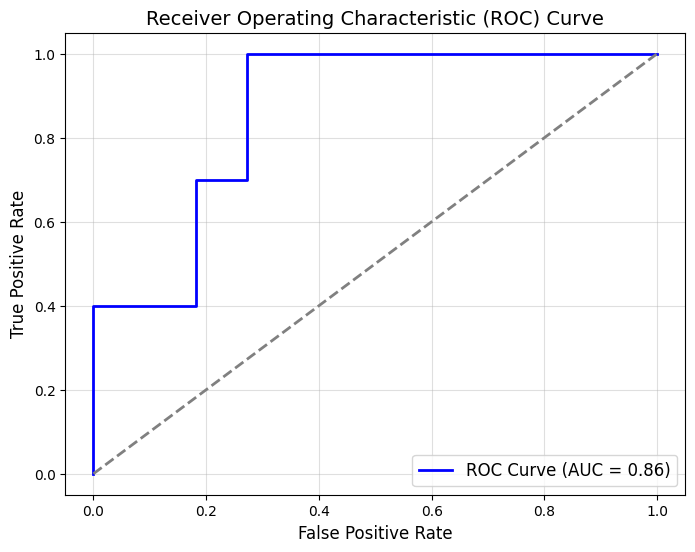

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_prob = ensemble.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line for random chance
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.4)  # Adjust grid transparency
plt.show()
